In [872]:
import jax.numpy as jnp
import numpy as np
from jax import grad, hessian
from jax import jit
import matplotlib.pyplot as plt

In [873]:
GlobalSeed = 42
ErrorsLevel = 10
FunctionComplexity = 5
Degree = 3

### Generate points based on desired polynomial with some error

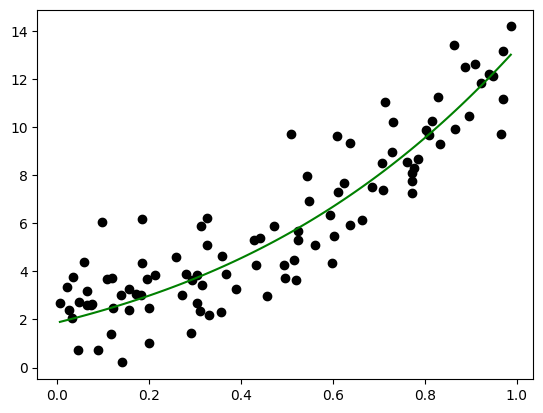

In [874]:
#set the random_seed
np.random.seed(GlobalSeed)

def predict(params,x):
    if(Degree == 10):
        return params[0] + params[1] * x + params[2] * x ** 2 + params[3] * x ** 3 + params[4] * x ** 4 + params[5] * x ** 5 + params[6] * x ** 6 + params[7] * x ** 7 + params[8] * x ** 8 + params[9] * x ** 9 + params[10] * x ** 10
    elif(Degree == 3):
        return params[0] + params[1] * x + params[2] * x ** 2 + params[3] * x ** 3

def generate_points(params,n, error):
    X = np.random.rand(n)
    Y = predict(params,X) + error*np.random.randn(n)
    return X, Y

params = np.random.rand(Degree + 1)*FunctionComplexity
X, Y = generate_points(params,100, 1.5)
#plot the function as well
X_org = jnp.linspace(min(X), max(X), 100)
Y_org = predict(params,X_org)
plt.plot(X_org, Y_org, color='green', label='Function')
plt.scatter(X, Y,color = 'black')

## Polynomial regression using Newton's method

In [875]:
# Define the loss function (mean squared error)
def loss(params, X, Y):
    predictions = predict(params, X)
    return jnp.mean((predictions - Y) ** 2)

grad_loss = jit(grad(loss))
hessian_loss = hessian(loss)

# Newton's method for polynomial regression
def newton_method(X, Y, num_iterations=10):
    params = np.zeros(Degree + 1)
    for i in range(num_iterations):
        grad_l = grad_loss(params, X, Y)
        hess_l = hessian_loss(params, X, Y)
        print(hess_l)
        
        #Add the damping factor to the hessian matrix to ensure that we are heading to teh minimum point.
        while jnp.any(jnp.linalg.eigvals(hess_l) <= 0):
            hess_l += 0.1 * jnp.eye(len(params))
        if jnp.linalg.cond(hess_l) < 1 / jnp.finfo(hess_l.dtype).eps:
            print(jnp.linalg.inv(hess_l))
            params_new = params - jnp.linalg.solve(hess_l, grad_l)
        else:
            print("Hessian is not invertible.")
            break
        params = params_new

        print(f"Iteration {i+1}, Parameters: {params}",)

    return params

def showNewton(X, Y):
    params = newton_method(X, Y)
    print("Final parameters:", params)

    #get the array of error for each X value
    error = Y - predict(params, X)

    # Plot the original data and the fitted curve
    plt.scatter(X, Y, color='black', label='Data points')
    X_fit = jnp.linspace(min(X), max(X), 100)
    Y_fit = predict(params, X_fit)
    plt.plot(X_fit, Y_fit, color='blue', label='Fitted curve')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()
    return X_fit,Y_fit,error

### Add outliers to the data

In [876]:
def AddOutliers(X, Y):
    #set the random_seed
    np.random.seed(GlobalSeed)
    # Calculate the standard deviation of the original data
    std_dev = np.std(Y)
    # Add outliers
    X_outliers = np.random.rand(5)

    # Add outlier which is between 1 and 3 std of the original data
    Y_outliers = predict(params, X_outliers) + np.random.uniform(-ErrorsLevel * std_dev, ErrorsLevel * std_dev, len(X_outliers))
    X_ol = np.concatenate((X, X_outliers))
    Y_ol = np.concatenate((Y, Y_outliers))
    return X_ol, Y_ol

In [877]:
def GaussianCalc(X):
    ave = jnp.mean(X)
    std = jnp.std(X)
    return 1/(std*jnp.sqrt(2*jnp.pi))*jnp.exp(-0.5*((X-ave)/std)**2)

In [878]:
def GaussianCurve(error):
    X_axis = jnp.linspace(-1.5*jnp.max(jnp.abs(error)), 1.5*jnp.max(jnp.abs(error)), 100)
    #Gaussian curve
    Y_axis = GaussianCalc(X_axis)
    #Plot the error distribution
    plt.plot(X_axis, Y_axis)
    #plot the vertical line for each one of the actual error value
    for i in range(len(error)):
        plt.axvline(error[i], color='red')
    
    std = jnp.std(error)
    #plot the axvline for the outlier threshold
    plt.axvline(2*std, color='green')
    plt.axvline(-2*std, color='green')

In [879]:
#remove outlier based on the gaussian curve
def removeOutliers(X, Y, error,threshold=2):
    ave = jnp.mean(error)
    std = jnp.std(error)
    X_new = []
    Y_new = []
    counter = 0
    for i in range(len(error)):
        if error[i] < threshold*std and error[i] > -threshold*std:
            counter+=1
            X_new.append(X[i])
            Y_new.append(Y[i])
    print(f"Number of outliers removed: {len(error)-counter}")
    return jnp.array(X_new), jnp.array(Y_new)

In [880]:
#Create the weighted loss function
def weighted_loss(params, X, Y, error):
    #for each point multiply the error by the corresponding y value of the gaussian curve
    weighted_error = GaussianCalc(error)
    predictions = predict(params, X)
    return jnp.mean((predictions - Y) ** 2 * weighted_error)

In [881]:
# Compute the gradient and Hessian of the loss function
grad_weighted_loss = jit(grad(weighted_loss))
hessian_weighted_loss = hessian(weighted_loss)

# Newton's method for polynomial regression
def newton_method_weighted(X, Y, num_iterations=10, tol=1e-6):
    #random initialization of the parameters using random function from np
    params = np.zeros(Degree + 1)
    for i in range(num_iterations):
        error = Y - predict(params,X)
        grad_weighted_l = grad_weighted_loss(params, X, Y,error)
        hess_weighted_l = hessian_weighted_loss(params, X, Y,error)
        print(hess_weighted_l)
        if jnp.linalg.cond(hess_weighted_l) < 1 / jnp.finfo(hess_weighted_l.dtype).eps:
            print(jnp.linalg.inv(hess_weighted_l))
            params_new = params - jnp.linalg.solve(hess_weighted_l, grad_weighted_l)
        else:
            print("Hessian is not invertible.")
            break
        params = params_new

        print(f"Iteration {i+1}, Parameters: {params}",)

    return params

def showNewton_weighted(X, Y,error):
    params = newton_method_weighted(X, Y, 10,error)
    print("Final parameters:", params)

    #get the array of error for each X value
    error = Y - predict(params, X)

    plt.ylim(0, 15)

    # Plot the original data and the fitted curve
    plt.scatter(X, Y, color='black', label='Data points')
    X_fit = jnp.linspace(min(X), max(X), 100)
    Y_fit = predict(params, X_fit)
    plt.plot(X_fit, Y_fit, color='blue', label='Fitted curve')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()
    return X_fit,Y_fit,error

In [882]:
class PlotConfig:
    def __init__(self, X, Y, label,color):
        self.x = X
        self.y = Y
        self.label = label
        self.color = color

In [883]:
from sklearn.metrics import mean_squared_error
def plot_and_calculate_rmse(plot_config1, plot_config2, title):
    plt.figure(figsize=(10, 6))
    plt.plot(plot_config1.x, plot_config1.y, color=plot_config1.color, label=plot_config1.label)
    plt.plot(plot_config2.x, plot_config2.y, color=plot_config2.color, label=plot_config2.label)
    plt.scatter(X,Y, color='black', label='Data points')
    plt.legend()
    plt.title(title)
    plt.show()
    rmse = np.sqrt(mean_squared_error(plot_config1.y, plot_config2.y))
    return rmse

[[1.9999999  0.9170587  0.5938723  0.43888247]
 [0.9170587  0.5938723  0.43888247 0.3472616 ]
 [0.5938723  0.43888247 0.3472616  0.2866246 ]
 [0.43888247 0.3472616  0.2866246  0.24355465]]
[[    6.4625177   -51.90217     107.32829     -63.951027 ]
 [  -51.90226     559.32495   -1294.5876      819.55945  ]
 [  107.32879   -1294.5894     3196.4446    -2109.2725   ]
 [  -63.95154     819.5616    -2109.2744     1433.0864   ]]
Iteration 1, Parameters: [ 2.8681276 -2.209371  16.875809  -4.471794 ]
[[1.9999999  0.9170587  0.5938723  0.43888247]
 [0.9170587  0.5938723  0.43888247 0.3472616 ]
 [0.5938723  0.43888247 0.3472616  0.2866246 ]
 [0.43888247 0.3472616  0.2866246  0.24355465]]
[[    6.4625177   -51.90217     107.32829     -63.951027 ]
 [  -51.90226     559.32495   -1294.5876      819.55945  ]
 [  107.32879   -1294.5894     3196.4446    -2109.2725   ]
 [  -63.95154     819.5616    -2109.2744     1433.0864   ]]
Iteration 2, Parameters: [ 2.8682806 -2.2111058 16.879988  -4.4745173]
[[1.99

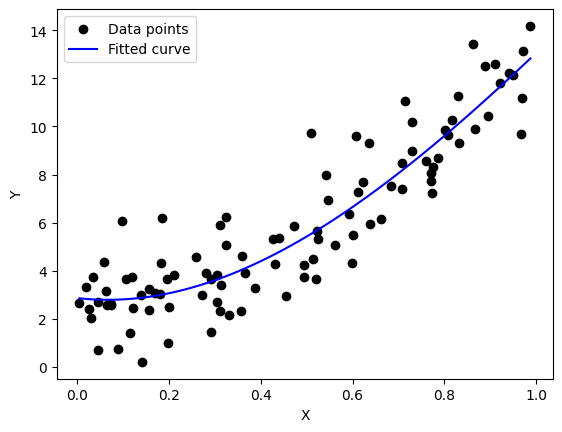

In [884]:
X_init_fit,Y_init_fit,error_init_fit = showNewton(X,Y)

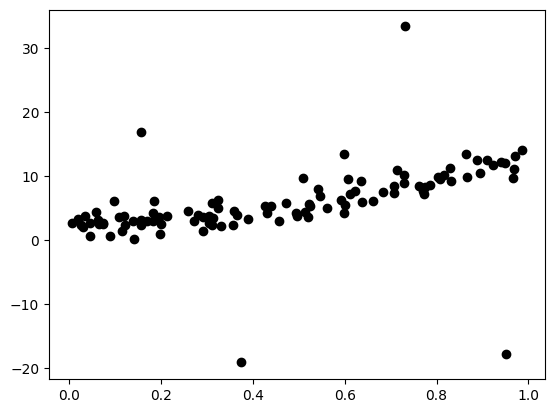

In [885]:
X_ol = AddOutliers(X,Y)[0]
Y_ol = AddOutliers(X,Y)[1]
plt.scatter(X_ol, Y_ol, color='black', label='Data points')

[[2.         0.9269497  0.60297716 0.44698182]
 [0.9269497  0.60297716 0.4469818  0.3545877 ]
 [0.60297716 0.4469818  0.35458767 0.29337978]
 [0.44698182 0.35458767 0.29337978 0.24988164]]
[[    6.711836   -53.61563    110.43533    -65.583435]
 [  -53.615993   570.59186  -1312.6625     827.3882  ]
 [  110.436485 -1312.6676    3218.0283   -2113.0474  ]
 [  -65.584366   827.39374  -2113.0527    1428.1094  ]]
Iteration 1, Parameters: [  4.569623 -24.347145  78.62968  -49.80088 ]
[[2.         0.9269497  0.60297716 0.44698182]
 [0.9269497  0.60297716 0.4469818  0.3545877 ]
 [0.60297716 0.4469818  0.35458767 0.29337978]
 [0.44698182 0.35458767 0.29337978 0.24988164]]
[[    6.711836   -53.61563    110.43533    -65.583435]
 [  -53.615993   570.59186  -1312.6625     827.3882  ]
 [  110.436485 -1312.6676    3218.0283   -2113.0474  ]
 [  -65.584366   827.39374  -2113.0527    1428.1094  ]]
Iteration 2, Parameters: [  4.569379 -24.344105  78.62201  -49.795746]
[[2.         0.9269497  0.60297716 0.4

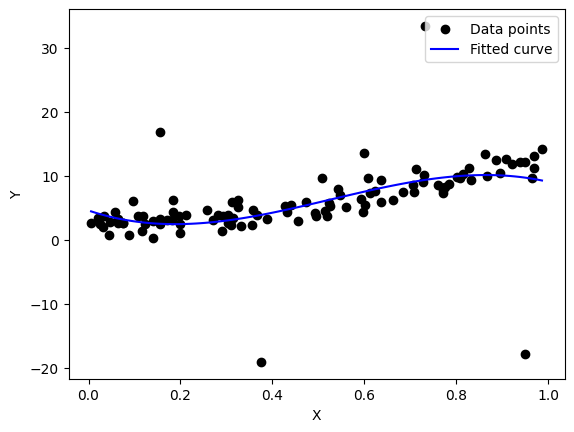

In [886]:
X_ol_fit,Y_ol_fit,error_ol_fit = showNewton(X_ol,Y_ol)

Number of outliers removed: 4
[[1.9999996  0.91983354 0.5950892  0.4387857 ]
 [0.91983354 0.5950892  0.4387857  0.34636682]
 [0.5950892  0.4387857  0.34636682 0.28530943]
 [0.4387857  0.34636682 0.28530943 0.24205476]]
[[    6.5277934   -52.41917     108.363       -64.55171  ]
 [  -52.41921     564.52734   -1305.2893      825.75775  ]
 [  108.36317   -1305.2891     3216.6223    -2120.0657   ]
 [  -64.55176     825.75745   -2120.0652     1438.4513   ]]
Iteration 1, Parameters: [ 2.886613  -2.9100494 20.290754  -7.4064536]
[[1.9999996  0.91983354 0.5950892  0.4387857 ]
 [0.91983354 0.5950892  0.4387857  0.34636682]
 [0.5950892  0.4387857  0.34636682 0.28530943]
 [0.4387857  0.34636682 0.28530943 0.24205476]]
[[    6.5277934   -52.41917     108.363       -64.55171  ]
 [  -52.41921     564.52734   -1305.2893      825.75775  ]
 [  108.36317   -1305.2891     3216.6223    -2120.0657   ]
 [  -64.55176     825.75745   -2120.0652     1438.4513   ]]
Iteration 2, Parameters: [ 2.8865316 -2.9090598

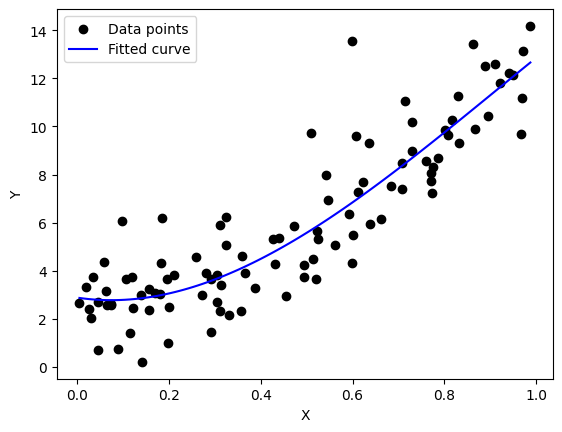

Number of outliers removed: 6
[[2.         0.9063848  0.5801953  0.42389804]
 [0.9063848  0.5801953  0.423898   0.33160627]
 [0.5801953  0.423898   0.33160627 0.27060807]
 [0.42389804 0.33160627 0.27060807 0.22735104]]
[[    6.466425   -52.46959    109.652466   -66.04178 ]
 [  -52.46961    570.9717   -1335.5802     854.72534 ]
 [  109.652374 -1335.5802    3333.2852   -2223.9111  ]
 [  -66.041794   854.72546  -2223.9114    1527.9059  ]]
Iteration 1, Parameters: [ 2.9228373 -3.0790026 19.59925   -6.662535 ]
[[2.         0.9063848  0.5801953  0.42389804]
 [0.9063848  0.5801953  0.423898   0.33160627]
 [0.5801953  0.423898   0.33160627 0.27060807]
 [0.42389804 0.33160627 0.27060807 0.22735104]]
[[    6.466425   -52.46959    109.652466   -66.04178 ]
 [  -52.46961    570.9717   -1335.5802     854.72534 ]
 [  109.652374 -1335.5802    3333.2852   -2223.9111  ]
 [  -66.041794   854.72546  -2223.9114    1527.9059  ]]
Iteration 2, Parameters: [ 2.9228761 -3.0795403 19.600683  -6.663532 ]
[[2.    

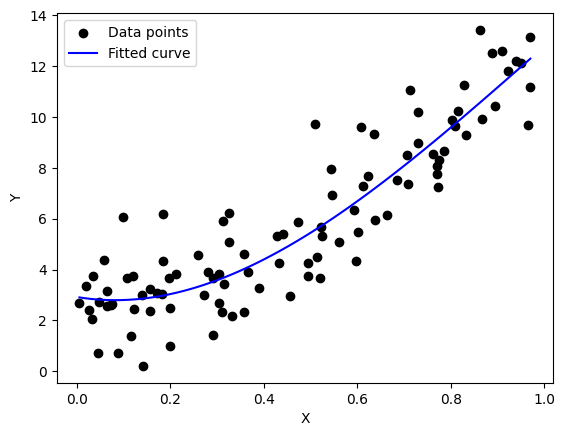

Number of outliers removed: 4
[[1.9999996  0.91983354 0.5950892  0.4387857 ]
 [0.91983354 0.5950892  0.4387857  0.34636682]
 [0.5950892  0.4387857  0.34636682 0.28530943]
 [0.4387857  0.34636682 0.28530943 0.24205476]]
[[    6.5277934   -52.41917     108.363       -64.55171  ]
 [  -52.41921     564.52734   -1305.2893      825.75775  ]
 [  108.36317   -1305.2891     3216.6223    -2120.0657   ]
 [  -64.55176     825.75745   -2120.0652     1438.4513   ]]
Iteration 1, Parameters: [ 2.886613  -2.9100494 20.290754  -7.4064536]
[[1.9999996  0.91983354 0.5950892  0.4387857 ]
 [0.91983354 0.5950892  0.4387857  0.34636682]
 [0.5950892  0.4387857  0.34636682 0.28530943]
 [0.4387857  0.34636682 0.28530943 0.24205476]]
[[    6.5277934   -52.41917     108.363       -64.55171  ]
 [  -52.41921     564.52734   -1305.2893      825.75775  ]
 [  108.36317   -1305.2891     3216.6223    -2120.0657   ]
 [  -64.55176     825.75745   -2120.0652     1438.4513   ]]
Iteration 2, Parameters: [ 2.8865316 -2.9090598

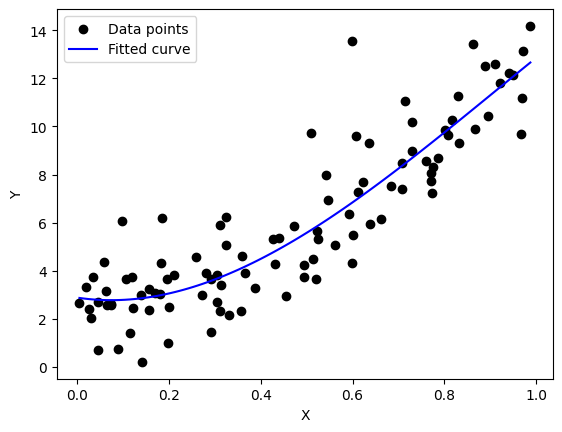

In [887]:
X_new2, Y_new2 = removeOutliers(X_ol, Y_ol, error_ol_fit,2)
X_ol_removed_fit2,Y_ol_removed_fit2,error_ol_removed_fit2 = showNewton(X_new2,Y_new2)
X_new1, Y_new1 = removeOutliers(X_ol, Y_ol, error_ol_fit,1)
X_ol_removed_fit1,Y_ol_removed_fit1,error_ol_removed_fit1 = showNewton(X_new1,Y_new1)
X_new3, Y_new3 = removeOutliers(X_ol, Y_ol, error_ol_fit,3)
X_ol_removed_fit3,Y_ol_removed_fit3,error_ol_removed_fit3 = showNewton(X_new3,Y_new3)

[[0.11601494 0.05094133 0.03131902 0.02204279]
 [0.05094133 0.03131902 0.02204279 0.01669872]
 [0.03131902 0.02204279 0.01669872 0.01326672]
 [0.02204279 0.01669872 0.01326672 0.01090392]]
[[   112.903885   -912.53796    1914.2642    -1159.8137  ]
 [  -912.543      9863.334    -23176.383     14938.17    ]
 [  1914.2852   -23176.479     58110.883    -39079.496   ]
 [ -1159.8314    14938.277    -39079.605     27107.146   ]]
Iteration 1, Parameters: [ 3.0276291 -1.7468015 15.271511  -3.8429148]
[[0.1509423  0.06918955 0.04481745 0.03311713]
 [0.06918955 0.04481745 0.03311713 0.02619463]
 [0.04481745 0.03311713 0.02619463 0.0216106 ]
 [0.03311713 0.02619463 0.0216106  0.01835368]]
[[    84.69945   -680.4107    1407.056     -838.48145]
 [  -680.4141    7357.804   -17046.266    10797.746  ]
 [  1407.0688  -17046.312    42142.996   -27831.559  ]
 [  -838.49133  10797.793   -27831.598    18927.084  ]]
Iteration 2, Parameters: [ 2.8710296 -2.3024297 17.224686  -4.767584 ]
[[0.15082714 0.0691736

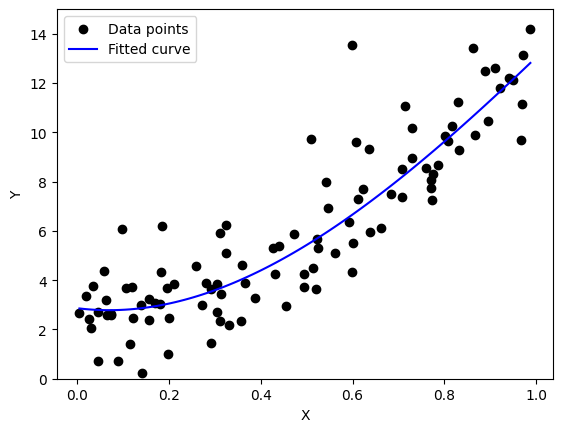

In [888]:
X_weighted_fit,Y_weighted_fit,error_ol_weighted_fit = showNewton_weighted(X_ol,Y_ol,error_ol_fit)

In [889]:
original = PlotConfig(X_org, Y_org, 'Original function', 'green')
init_fit = PlotConfig(X_init_fit, Y_init_fit, 'Fitted curve without outliers', 'blue')
ol_fit = PlotConfig(X_ol_fit, Y_ol_fit, 'Fitted curve with outliers', 'red')
ol_removed_fit2 = PlotConfig(X_ol_removed_fit2, Y_ol_removed_fit2, 'Fitted curve with outliers removed', 'orange')
ol_removed_fit1 = PlotConfig(X_ol_removed_fit1, Y_ol_removed_fit1, 'Fitted curve with outliers removed1', 'purple')
ol_removed_fit3 = PlotConfig(X_ol_removed_fit3, Y_ol_removed_fit3, 'Fitted curve with outliers removed2', 'pink')
weighted_fit = PlotConfig(X_weighted_fit, Y_weighted_fit, 'Fitted curve with weighted loss', 'yellow')

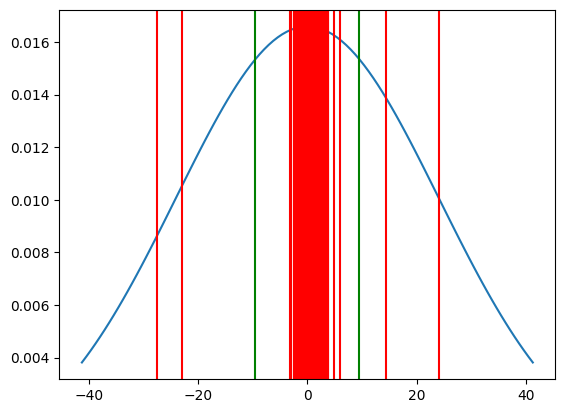

In [890]:
GaussianCurve(error_ol_fit)

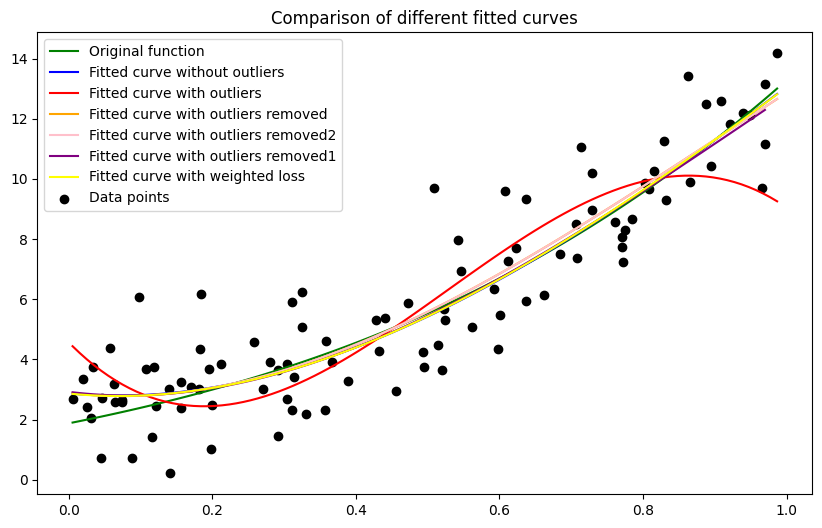

In [891]:
#cast every function on one plot without using the function made
plt.figure(figsize=(10, 6))
plt.plot(original.x, original.y, color=original.color, label=original.label)
plt.plot(init_fit.x, init_fit.y, color=init_fit.color, label=init_fit.label)
plt.plot(ol_fit.x, ol_fit.y, color=ol_fit.color, label=ol_fit.label)
plt.plot(ol_removed_fit2.x, ol_removed_fit2.y, color=ol_removed_fit2.color, label=ol_removed_fit2.label)
plt.plot(ol_removed_fit3.x, ol_removed_fit3.y, color=ol_removed_fit3.color, label=ol_removed_fit3.label)
plt.plot(ol_removed_fit1.x, ol_removed_fit1.y, color=ol_removed_fit1.color, label=ol_removed_fit1.label)
plt.plot(weighted_fit.x, weighted_fit.y, color=weighted_fit.color, label=weighted_fit.label)
plt.scatter(X,Y, color='black', label='Data points')
plt.legend()
plt.title('Comparison of different fitted curves')
plt.show()

In [892]:
# Function to calculate RMSE
def calculate_rmse(y_true, y_pred):
    return jnp.mean((y_true - y_pred) ** 2)

# Generate a common set of X values for comparison
X_comp = jnp.linspace(min(X), max(X), 100)

# Compute RMSE for each fitted curve
rmse_init = float(calculate_rmse(Y_org, Y_init_fit))
rmse_ol = float(calculate_rmse(Y_org, Y_ol_fit))
rmse_ol_removed2 = float(calculate_rmse(Y_org, Y_ol_removed_fit2))
rmse_ol_removed1 = float(calculate_rmse(Y_org, Y_ol_removed_fit1))
rmse_ol_removed3 = float(calculate_rmse(Y_org, Y_ol_removed_fit3))
rmse_ol_weighted = float(calculate_rmse(Y_org, Y_weighted_fit))

# Print RMSE values
#print(f"RMSE without outliers: {rmse_init}")
#print(f"RMSE with outliers: {rmse_ol}")
print(f"RMSE with outliers removed1: {rmse_ol_removed1}")
print(f"RMSE with outliers removed2: {rmse_ol_removed2}")
print(f"RMSE with outliers removed3: {rmse_ol_removed3}")
#print(f"RMSE with weighted loss outliers: {rmse_ol_weighted}")

#use pandas and put it in table
import pandas as pd

# Data dictionary
data = {'Root Mean Square Error': [rmse_ol, rmse_ol_removed1, rmse_ol_removed2, rmse_ol_removed3, rmse_ol_weighted]}

# Create DataFrame
df = pd.DataFrame(data, index=[
    'With Outliers',
    'Outliers Removed 1',
    'Outliers Removed 2',
    'Outliers Removed 3',
    'Weighted Loss'
])

# Display DataFrame
df

RMSE with outliers removed1: 0.10873651504516602
RMSE with outliers removed2: 0.07187049090862274
RMSE with outliers removed3: 0.07187049090862274


,Root Mean Square Error
With Outliers,1.192707
Outliers Removed 1,0.108737
Outliers Removed 2,0.071870
Outliers Removed 3,0.071870
Weighted Loss,0.061620
